In [1]:
%reset -f

# Camera Calibration

Below is the code for camera Calibration. As asked in the project I creating a mapping from 3D 9x6 chess to 2D image points and then pass that mapping to openCV function to get distortion and camera calibration matrix. 

In [2]:
import numpy as np
import glob
import matplotlib.pyplot as plt
import cv2
import matplotlib.image as mpimg
import pickle
import random
%matplotlib qt

def get_3d_to_2d_mapping(images_path_pattern, nx, ny):
    # prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
    objp = np.zeros((ny*nx, 3), np.float32)
    objp[:,:2] = np.mgrid[0:nx, 0:ny].T.reshape(-1, 2)

    # Arrays to store object points and image points from all the images.
    objpoints = [] # 3d points in real world space
    imgpoints = [] # 2d points in image plane.

    # Make a list of calibration images
    images = glob.glob(images_path_pattern)

    # Step through the list and search for chessboard corners
    for fname in images:
        img = cv2.imread(fname)
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        # Find the chessboard corners
        ret, corners = cv2.findChessboardCorners(gray, (nx,ny), None)

        # If found, add object points, image points
        if ret == True:
            objpoints.append(objp)
            imgpoints.append(corners)

            cv2.drawChessboardCorners(img, (nx,ny), corners, ret)
#             cv2.imshow('img', img)
#             cv2.waitKey(500)

#     cv2.destroyAllWindows()
    return (objpoints, imgpoints)

In [3]:
#find 3d to mapping points to calibrate camera
(objpoints, imgpoints) = get_3d_to_2d_mapping("camera_cal/calibration*.jpg", nx=9, ny=6)

In [4]:
%matplotlib inline
def calibrate_camera(test_img_path):
    # Test undistortion on an image
    img = mpimg.imread(test_img_path)
    img_size = (img.shape[1], img.shape[0])

    # Do camera calibration given object points and image points
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size, None, None)

    undst_img = cv2.undistort(img, mtx, dist, None, mtx)

    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
    # plt.figure(figsize=(20,10))
    ax1.set_title("Original Image")
    ax1.imshow(img)

    # plt.figure(figsize=(20,10))
    ax2.set_title("Undistorted Image")
    ax2.imshow(undst_img)
    
    f.savefig('output_images/undistorted_fig.jpg', bbox_inches='tight')
    cv2.imwrite('output_images/undistorted_test_img.jpg', undst_img)

    data = {}
    data["mtx"] = mtx
    data["dist"] = dist
    pickle.dump(data, open("camera_cal/cam_calibration.p", "wb"))
    
    return (mtx, dist)

**Here I am calibrating camera and testing it on a sample chess image to see if it is undistoring image or not.**

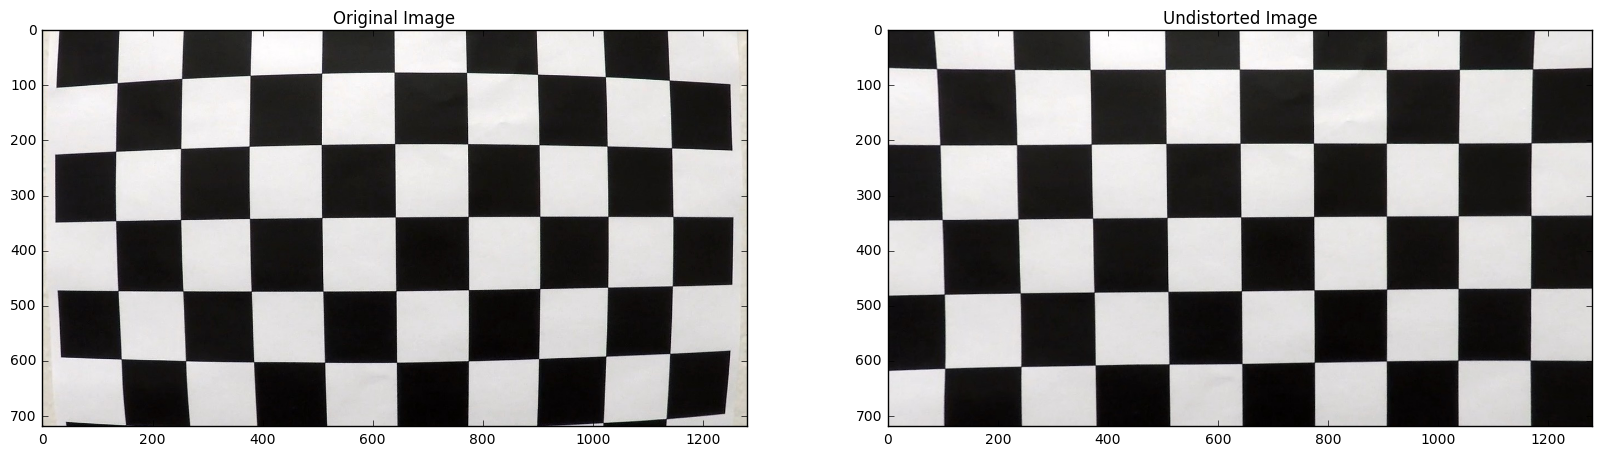

In [5]:
#let's calibrate camera to find camera matrix and distortion
(mtx, dist) = calibrate_camera("camera_cal/calibration1.jpg")

# Image Undistortion 

**Here I am undistoring an actual road image. **

In [6]:
def undistort_img(img, mtx, dist):
    return cv2.undistort(img, mtx, dist, None, mtx)

def undistort_test_img(mtx, dist):
    test_image = mpimg.imread("test_images/straight_lines2.jpg")
    undistorted_img = undistort_img(test_image, mtx, dist)
    
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
    # plt.figure(figsize=(20,10))
    ax1.set_title("Original Image")
    ax1.imshow(test_image)

    # plt.figure(figsize=(20,10))
    ax2.set_title("Undistorted Image")
    ax2.imshow(undistorted_img)
    
    f.savefig('output_images/undistorted_fig2.jpg', bbox_inches='tight')
    cv2.imwrite('output_images/undistorted_test_img2.jpg', undistorted_img)

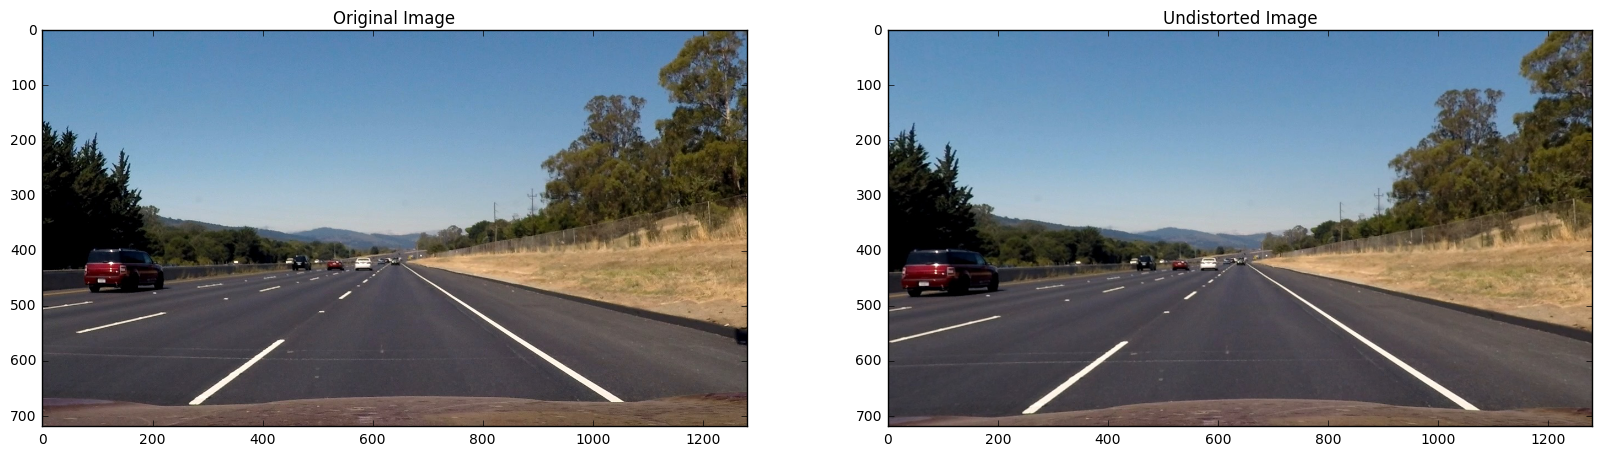

In [7]:
undistort_test_img(mtx, dist)

# Perspective Transform

Here I have selected four hard-coded src and destination points to perform perspective transform. All these points were selected by looking at straight_lines1.jpg image (provided by Udacity in test_images folder) |visually and then looking at resultant warped image to see if lines in resultant image are roughly straight and parallel. I have drawn a trapezoidal shape on test image to show what points I actually selected. 

In [8]:
#src points 
src = np.float32([
         [203, 720], #bottom left
        [585, 460],  #top left
         [695, 460], #top right
         [1127, 720]]) #bottom right
#destination points
dst = np.float32([
         [270, 720], #bottom left
        [310, 0],   #top left
         [960, 0], # top right
         [1010, 720]]) #bottom right

def draw_polygon(image):
    vertices= np.array([[
        tuple(src[0]), #bottom left
        tuple(src[1]), #top left
        tuple(src[2]), #top right
        tuple(src[3])]], #bottom right
        dtype=np.int32)
    
    copy_image = np.copy(image)
    cv2.polylines(copy_image, vertices, True, (255, 0,0), 4)
    return copy_image

def get_perspective_transform_params():
    #perspective transform matrix
    M = cv2.getPerspectiveTransform(src, dst)
    #get inverse perspective transform matrix for latter use
    Minv = cv2.getPerspectiveTransform(dst, src)
    
    return (M, Minv)

def draw_dst_lines(img):
    cv2.line(img, tuple(dst[0]), tuple(dst[1]), (255, 0, 0), 8)
    cv2.line(img, tuple(dst[3]), tuple(dst[2]), (255, 0, 0), 8)
    
    return img

In [9]:
(M, Minv) = get_perspective_transform_params()

**Testing to see if my perspective transform is correct (lines are roughly parallel or not).**

In [10]:
#testing perspective transform on a test image
def perspective_transform_test_img():
    test_image = mpimg.imread("test_images/straight_lines1.jpg")
    img_size = (test_image.shape[1], test_image.shape[0])
    undistorted_img = undistort_img(test_image, mtx, dist)
    i = draw_polygon(undistorted_img)
    warped = cv2.warpPerspective(undistorted_img, M, img_size)
#     warped = draw_dst_lines(warped)
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
    ax1.set_title("Original Image")
    ax1.imshow(i)

    ax2.set_title("Undistorted Warped Image")
    ax2.imshow(warped)
    
    f.savefig('output_images/perspective_transform_fig.jpg', bbox_inches='tight')
    cv2.imwrite('output_images/perspective_transform.jpg', warped)

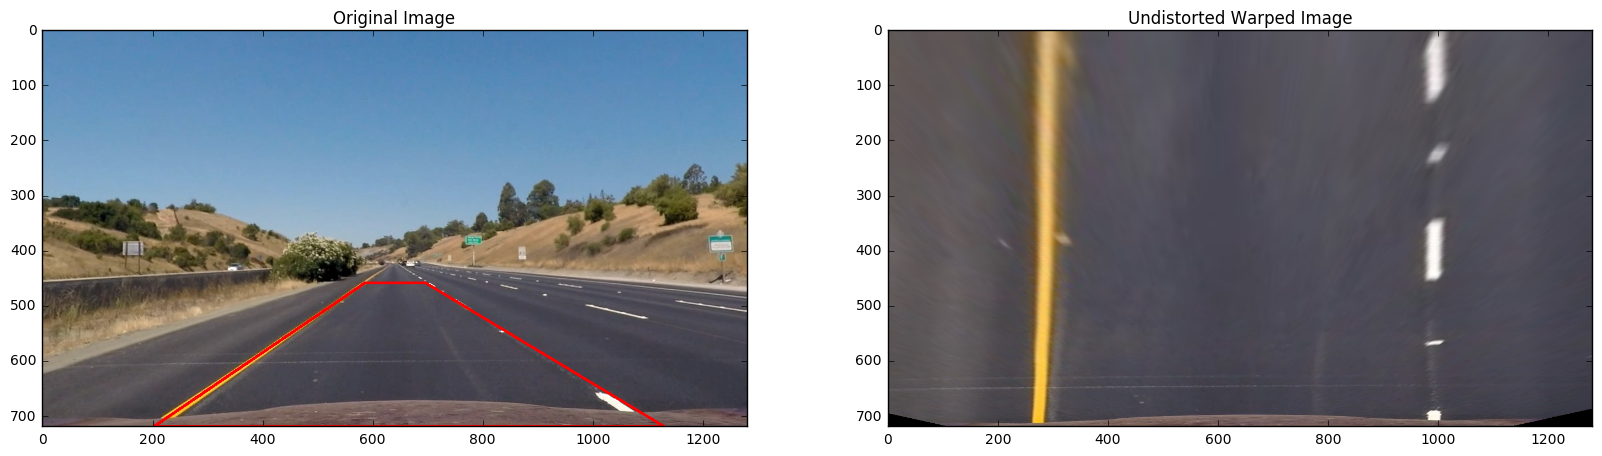

In [11]:
perspective_transform_test_img()

# Thresholding/Edge Detection

This code section defines the complete edge detection pipeline. I have used combination of
- Gradients using **Sobel** Operator in X direction, **threshold = (20, 100)**
- S channel thresholding by converting image to **HLS** color space, **threshold = (170, 255)**

In [12]:
#apply sobel operator to find smoothed gradients on a gray img
def abs_thresh_sobel(img, orient='x', sobel_kernel=9, thresh=(0, 255)):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    if orient == 'x':
        sobel = cv2.Sobel(gray, cv2.CV_64F, 1, 0)
    else:
        sobel = cv2.Sobel(gray, cv2.CV_64F, 0, 1)
    
    abs_sobel = np.absolute(sobel)
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    
    sbinary = np.zeros_like(scaled_sobel)
    sbinary[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    
    return sbinary

#convert image to HLS color space and apply thresholding on S channel
def hls_s_thresh(img, thresh=(0, 255)):
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    S = hls[:, :, 2]
    
    S_binary = np.zeros_like(S)
    S_binary[(S >= thresh[0]) & (S <= thresh[1])] = 1
    
    return S_binary

#combine gray thresholded and S channel thresholded image into one image and
#also return a colored image to show contribution of each channel
def combine(sxbinary, sbinary):
    # Stack each channel to view their individual contributions in green and blue respectively
    # This returns a stack of the two binary images, whose components you can see as different colors
    color_binary = np.dstack((np.zeros_like(sxbinary), sxbinary*255, sbinary*255))
    
    combined_binary = np.zeros_like(sxbinary)
    combined_binary[(sxbinary == 1) | (sbinary == 1)] = 1
    
    return (color_binary, combined_binary)

#combines gradient thresholding using Sobel operator and S channel thresholding
def find_edges(img, s_thresh=(170, 255), sx_thresh=(20, 100)):
    #apply S channel thresholding by converting image to HLS color space
    sbinary = hls_s_thresh(img, s_thresh)
    #apply Sobel x operator
    sxbinary = abs_thresh_sobel(img, orient='x', thresh=sx_thresh)

    (color_binary, combined_binary) = combine(sxbinary, sbinary)
    return (color_binary, combined_binary)

#this function combines following stages for convinience 
#1. image undistortion 
#2. edge detection
#3. persepctive transform
def get_undistorted_warped_binary_img(img):
    img = undistort_img(img, mtx, dist)
    color_binary, edges_img = find_edges(img)
    img_size = (edges_img.shape[1], edges_img.shape[0])
    warped_img = cv2.warpPerspective(edges_img, M, img_size, flags=cv2.INTER_LINEAR)
    
    return warped_img

#testing on a test image to if it works
def find_edges_on_test_image():
    test_image = mpimg.imread("test_images/straight_lines1.jpg")
#     test_image = undistort_img(test_image, mtx, dist)
    color_binary, edges_img = find_edges(test_image)
    
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
    # plt.figure(figsize=(20,10))
    ax1.set_title("Original Image")
    ax1.imshow(test_image)

    # plt.figure(figsize=(20,10))
    ax2.set_title("Edges Detected")
    ax2.imshow(edges_img, cmap='gray')
    
    f.savefig('output_images/edges_fig.jpg', bbox_inches='tight')
    d3_edges_img = np.dstack((edges_img, edges_img, edges_img)) * 255
    cv2.imwrite('output_images/edges_img.jpg', d3_edges_img)
    
    p = get_undistorted_warped_binary_img(test_image)
    
    plt.figure()
    plt.title("Perspective Transform")
    plt.imshow(p, cmap='gray')

**Testing edge detection on a test image to see if it works fine.**

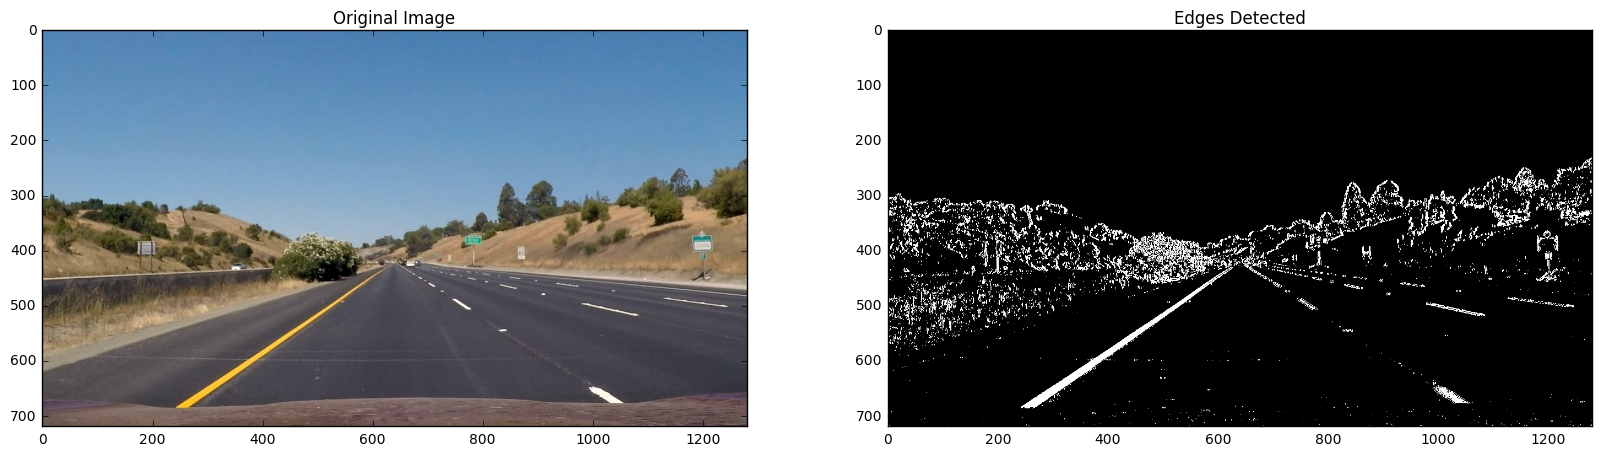

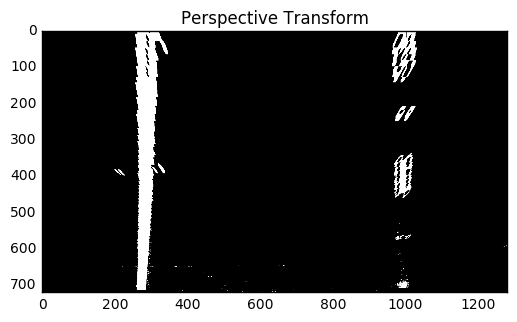

In [13]:
#test on an image to see it is working
find_edges_on_test_image()

# Locate and Fit Lane Lines

**Following are some utility functions that are used by main polynomial fitting functions. **

In [21]:
#defining some constants and utility functions needed 
LINE_LENGTH_METERS = 30
LINE_WIDTH_METERS = 3.7
# left_lane = Lane()
# right_lane = Lane()

def random_color():
    rgbl=[255,0,0]
    random.shuffle(rgbl)
    return tuple(rgbl)

#just for visualizing non-zero pixels 
def visualize_lane_inds(output_img, nonzerox, nonzeroy, lane_inds):
    if len(output_img.shape) < 3:
        output_img[nonzeroy[lane_inds], nonzerox[lane_inds]] = 255
    else:
        output_img[nonzeroy[lane_inds], nonzerox[lane_inds]] = random_color()

#find non-zero pixels that are inside window boundary
def find_good_lane_inds_in_window(warped_binary_img, output_img, 
                                  nonzerox, nonzeroy,
                                  current_window, window_centerx,
                                  window_width, window_height):
    # Identify window boundaries in x and y (and right and left)
    win_y_low = warped_binary_img.shape[0] - (current_window + 1) * window_height
    win_y_high = warped_binary_img.shape[0] - current_window * window_height
    
    win_x_low = window_centerx - window_width
    win_x_high = window_centerx + window_width
    
    # Draw the windows on the visualization image
    cv2.rectangle(output_img, (win_x_low, win_y_low), (win_x_high, win_y_high), (255, 0, 0), 2)
    # Identify the nonzero pixels in x and y within the window boundary
    good_lane_inds = ((nonzerox >= win_x_low) & (nonzerox < win_x_high) 
                      & (nonzeroy >= win_y_low) & (nonzeroy < win_y_high)).nonzero()[0]
    
    return good_lane_inds
    
#recenter window based on found non-zero pixels 
def recenter_windowx(nonzerox, good_lane_inds, 
                    minpix_to_recenter, current_window_centerx):
    
    new_window_centerx = current_window_centerx
    if len(good_lane_inds) >= minpix_to_recenter:
        new_window_centerx = np.int(np.mean(nonzerox[good_lane_inds]))
        
    return new_window_centerx

#this function returns lane indices based on sliding window search technique
def find_lane_inds_with_sliding_window(warped_binary_img, output_img, 
                                window_centerx):
    current_window_centerx = window_centerx
    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(warped_binary_img.shape[0]/nwindows)
    # Set the width of the windows +/- margin
    window_width = 50
    # Set minimum number of pixels found to recenter window
    minpix_to_recenter_window = 50
    
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = warped_binary_img.nonzero()
    nonzerox = np.array(nonzero[1])
    nonzeroy = np.array(nonzero[0])
    
    lane_inds = []
    
    for window in range(nwindows):
        #find nonzero pixels indexes in this window
        good_lane_inds = find_good_lane_inds_in_window(warped_binary_img, output_img, 
                                                   nonzerox, nonzeroy, 
                                                   window, current_window_centerx, 
                                                   window_width, window_height)
        #append found indexes to overall lane indexes
        lane_inds.append(good_lane_inds)
        # If we found > minpix pixels, recenter next window on their mean position
        current_window_centerx = recenter_windowx(nonzerox, good_lane_inds, 
                                     minpix_to_recenter_window, 
                                     current_window_centerx)
        
        
    # Concatenate the arrays of indices
    #, as after appending they are a collection of multiple arrays 
    lane_inds = np.concatenate(lane_inds)
    
    #draw found inds on output image
    visualize_lane_inds(output_img, nonzerox, nonzeroy, lane_inds)
    
    # Extract left and right line pixel positions
    x = nonzerox[lane_inds]
    y = nonzeroy[lane_inds]
    return (x, y)
    
    
#to visualize how polynomial was fit 
def visualize_poly_fit(binary_img, output_img, left_fit, right_fit):
    #generate y indices for plotting
    y = np.linspace(0, binary_img.shape[0] - 1, binary_img.shape[0])
    #now using 2-degree polynomial fit to find x indices for corresponding (above generated) y indices
    #here '**" operator is of taking "power"
    left_fitx = left_fit[0] * (y ** 2) + left_fit[1] * y + left_fit[2]
    right_fitx = right_fit[0] * (y ** 2) + right_fit[1] * y + right_fit[2]
    
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
    # plt.figure(figsize=(20,10))
    ax1.set_title("Original Image")
    ax1.imshow(binary_img, cmap='gray')

    # plt.figure(figsize=(20,10))
    ax2.set_title("Lanes Detected Image")
    ax2.imshow(output_img)
    plt.plot(left_fitx, y, color='yellow')
    plt.plot(right_fitx, y, color='yellow')
    
    f.savefig('output_images/lanes_detected_fig.jpg', bbox_inches='tight')
    
#     f = plt.figure()
#     plt.imshow(output_img)
#     plt.plot(left_fitx, y, color='yellow')
#     plt.plot(right_fitx, y, color='yellow')

#returns non-zero lane indices that are inside a window around passed polynomial fit
def find_lane_inds_with_poly_fit(warped_binary_img, output_img, 
                                    fit, nonzerox, nonzeroy, window_width):
    x_low = fit[0] * (nonzeroy ** 2) + fit[1] * nonzeroy + fit[2] - window_width
    x_high = fit[0] * (nonzeroy ** 2) + fit[1] * nonzeroy + fit[2] + window_width
    
    lane_inds = ((nonzerox >= x_low) & (nonzerox < x_high))
    #draw found inds on output image
    visualize_lane_inds(output_img, nonzerox, nonzeroy, lane_inds)
    
    x = nonzerox[lane_inds]
    y = nonzeroy[lane_inds]
    
    return (x, y)

#this is for drawing purposes 
def make_line_window(x1, y1, x2, y2):
    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    line_window1 = np.array([np.transpose(np.vstack([x1, y1]))])
    line_window2 = np.array([np.flipud(np.transpose(np.vstack([x2, y2])))])
    
    line_window = np.array(np.hstack((line_window1, line_window2)))
    return line_window

#visualize polyfit which was fit based on a passed polynomial fit (not sliding window fit)
def visualize_poly_fit_with_original_fit(warped_binary, output_img, left_fit, right_fit):
    window_width = 50
    #generate y indices for plotting
    y = np.linspace(0, warped_binary.shape[0] - 1, warped_binary.shape[0])
    
    #now using 2-degree polynomial fit to find x indices for corresponding (above generated) y indices
    #here '**" operator is of taking "power"
    leftx = left_fit[0] * (y ** 2) + left_fit[1] * y + left_fit[2]
    rightx = right_fit[0] * (y ** 2) + right_fit[1] * y + right_fit[2]
    
    # Create an image to draw on and an image to show the selection window
    window_img = np.zeros_like(output_img)
    
    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window = make_line_window(leftx - window_width, y, leftx + window_width, y)
    right_line_window = make_line_window(rightx - window_width, y, rightx + window_width, y)
    
    cv2.fillPoly(window_img, np.int_([left_line_window]), (0, 255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_window]), (0, 255, 0))
    
    combined_img = cv2.addWeighted(output_img, 1, window_img, 0.3, 0)
    plt.figure()
    plt.imshow(combined_img)
    
    plt.plot(leftx, y, color='yellow')
    plt.plot(rightx, y, color='yellow')
    
#for drawing purpose
def fill_lane_lines(warped_binary, output_img, left_fit, right_fit):
    #generate y indices for plotting
    y = np.linspace(0, warped_binary.shape[0] - 1, warped_binary.shape[0])
    
    #now using 2-degree polynomial fit to find x indices for corresponding (above generated) y indices
    #here '**" operator is of taking "power"
    leftx = left_fit[0] * (y ** 2) + left_fit[1] * y + left_fit[2]
    rightx = right_fit[0] * (y ** 2) + right_fit[1] * y + right_fit[2]
    
    # Create an image to draw on and an image to show the selection window
    window_img = np.zeros_like(output_img)
    
    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    line_window = make_line_window(leftx, y, rightx, y)
    cv2.fillPoly(window_img, np.int_([line_window]), (0, 255, 0))
    
    combined_img = cv2.addWeighted(output_img, 1, window_img, 0.3, 0)
    f = plt.figure()
    plt.imshow(combined_img)
    plt.plot(leftx, y, color='yellow')
    plt.plot(rightx, y, color='yellow')
    
    return combined_img

**Following are main functions responsible for polynomial fitting. One fits using sliding window and other fits using original polinomial fitting passed as parameter. **

In [22]:
def fit_poly_with_sliding_window(warped_binary_img, output_img):
    # Assuming you have created a warped binary image called "binary_warped"
    # Take a histogram of the bottom half of the image
    #let's take histogram of lower half of the image along all the columns
    img_y_half = warped_binary_img.shape[0]//3
    histogram = np.sum(warped_binary_img[img_y_half:, :], axis=0)

    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    (leftx, lefty) = find_lane_inds_with_sliding_window(warped_binary_img, output_img, 
                                leftx_base)
    (rightx, righty) = find_lane_inds_with_sliding_window(warped_binary_img, output_img, 
                                rightx_base)
    
    
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    return (left_fit, right_fit)

def fit_poly_with_original_fit(warped_binary_img, output_img, left_fit, right_fit):
    # Set the width of the windows +/- margin
    window_width = 50
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = warped_binary_img.nonzero()
    nonzerox = np.array(nonzero[1])
    nonzeroy = np.array(nonzero[0])
    
    (leftx, lefty) = find_lane_inds_with_poly_fit(warped_binary_img, output_img, 
                                    left_fit, nonzerox, nonzeroy, window_width)
    (rightx, righty) = find_lane_inds_with_poly_fit(warped_binary_img, output_img, 
                                    right_fit, nonzerox, nonzeroy, window_width)
    
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    return (left_fit, right_fit)

**This function serves as an entry point for other functions related to drawing and polynomial fitting.**

In [23]:
def process_img(img, prev_l_fit = None, prev_r_fit = None, show_visual=False):
    warped_binary = img
#     undistorted_img = undistort_img(img, mtx, dist)
#     warped_binary = get_undistorted_warped_binary_img(img)
    output_img = np.dstack((warped_binary, warped_binary, warped_binary)) * 255
    
    if((prev_l_fit is None) | (prev_r_fit is None)):
        (left_fit, right_fit) = fit_poly_with_sliding_window(warped_binary, output_img)
    else:
        (left_fit, right_fit) = fit_poly_with_original_fit(warped_binary, output_img, prev_l_fit, prev_r_fit)

    if show_visual == True:
        visualize_poly_fit(warped_binary, output_img, left_fit, right_fit)

#     result = draw_lines_on_original(undistorted_img, warped_binary, left_fit, right_fit)
    return (output_img, left_fit, right_fit)

## Testing Lane Detection in raw form on a test image 

This code section shows a demo of lane detection with sliding window working on a real image. This shows images in raw form to see how windows are moving and how line was fit over data

In [26]:
def try_lane_detection_on_test_img(test_image = None): 
    if (test_image is None):
        test_image = mpimg.imread("test_images/test6.jpg")
    undistorted_img = undistort_img(test_image, mtx, dist)
    warped_binary = get_undistorted_warped_binary_img(test_image)
    (result_img, left_fit, right_fit) = process_img(warped_binary, show_visual=True)
    

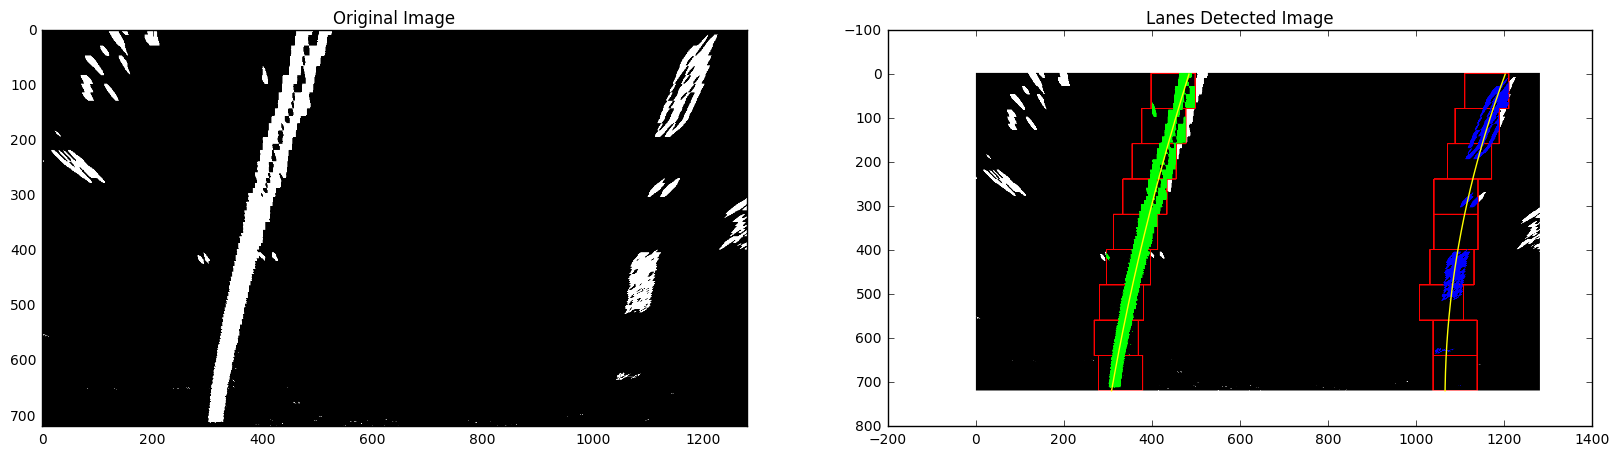

In [27]:
try_lane_detection_on_test_img()

## Lane Detection on Test images by Wraping Lanes back to Original Image

This tests lane detection on test images provided and also wraps the warped image back to original colored image using inverse perspective transform calculated above in perspective transform code section.

In [ ]:
# // %%javascript
# // IPython.OutputArea.prototype._should_scroll = function(lines) {
# //     return false;
# // }

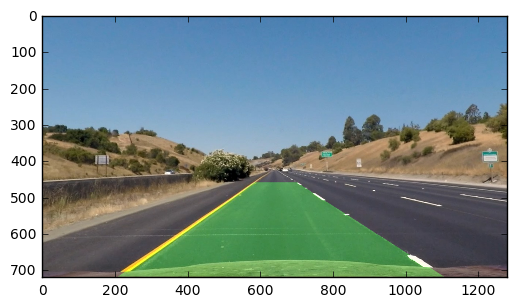

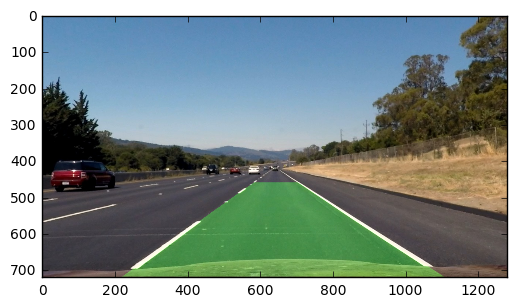

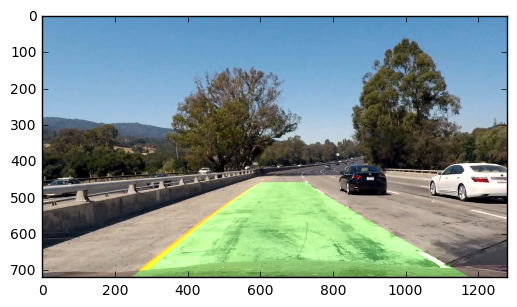

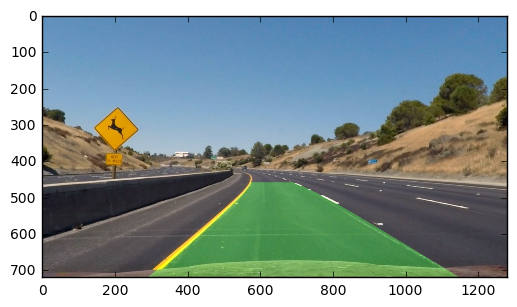

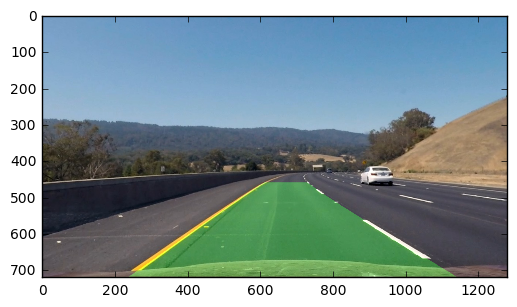

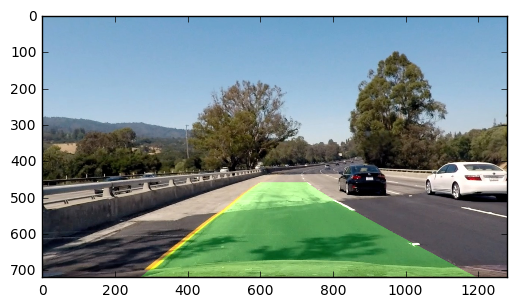

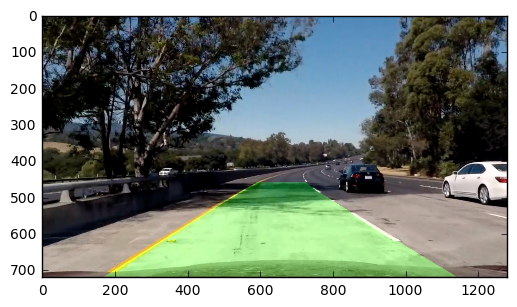

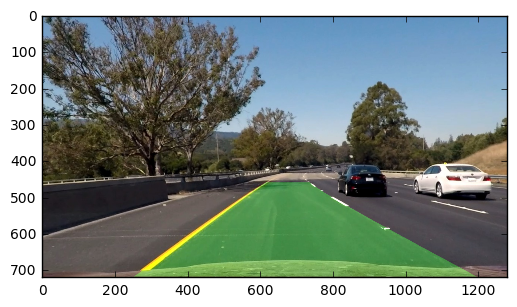

In [28]:
def draw_lines_on_original(undistorted_img, warped_img, poly_left_fit, poly_right_fit):
    #generate y indices for plotting
    y = np.linspace(0, warped_img.shape[0] - 1, warped_img.shape[0])
    
    #now using 2-degree polynomial fit to find x indices for corresponding (above generated) y indices
    #here '**" operator is of taking "power"
    left_fitx = poly_left_fit[0] * (y ** 2) + poly_left_fit[1] * y + poly_left_fit[2]
    right_fitx = poly_right_fit[0] * (y ** 2) + poly_right_fit[1] * y + poly_right_fit[2]
    
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(warped_img).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
#     color_warp = warped_img

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, y]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, y])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (warped_img.shape[1], warped_img.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(undistorted_img, 1, newwarp, 0.3, 0)
    
    return result

def test_lane_detection():
    # Make a list of calibration images
    images = glob.glob("test_images/*.jpg")
    for fname in images:
        img = mpimg.imread(fname)
        
        undistorted_img = undistort_img(img, mtx, dist)
        warped_binary = get_undistorted_warped_binary_img(img)
        (result, left_fit, right_fit) = process_img(warped_binary)
        result = draw_lines_on_original(undistorted_img, warped_binary, left_fit, right_fit)
        
        mpimg.imsave(("output_images/" + fname), result)
        plt.figure()
        plt.imshow(result)
        
test_lane_detection()

# Calculate Lane Curvature and Vehicle Offset From Center

Here I am calculating radius of curvature and vehicle offset from center. Both are in meters/pixel as first convert x,y in meters per pixel, then fit polynomial to fit in real world space and then calculate curvature. Same goes for vehicle offset. I have also written a function to calculate distance between two lane lines. 

In [57]:
#applies formula for calculation of radius of curvature 
def calculate_curvature(target_y, fit):
    A = fit[0]
    B = fit[1]
    
    curvature = ((1 + (2 * A * target_y + B) ** 2) ** 1.5) / np.absolute(2 * A)
    return curvature

#calculates radius of curvature of lane line
def calculate_lanes_curvature(warped_binary_img, left_fit, right_fit):
    # Define conversions in x and y from pixels space to meters
#     ym_per_pix = LINE_LENGTH_METERS/warped_binary_img.shape[0] # meters per pixel in y dimension
#     xm_per_pix = LINE_WIDTH_METERS/warped_binary_img.shape[1] # meters per pixel in x dimension

    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/warped_binary_img.shape[0] # meters per pixel in y dimension
    xm_per_pix = 3.7/warped_binary_img.shape[1] # meters per pixel in x dimension
    
    #generate y indices for plotting
    y = np.linspace(0, warped_binary_img.shape[0] - 1, warped_binary_img.shape[0])
    
    #now using 2-degree polynomial fit to find x indices for corresponding (above generated) y indices
    #here '**" operator is of taking "power"
    leftx = (left_fit[0] * (y ** 2) + left_fit[1] * y + left_fit[2]) 
    rightx = (right_fit[0] * (y ** 2) + right_fit[1] * y + right_fit[2]) 
    
    # Fit a second order polynomial to each by first converting x and y to meters per pixel
    # so that result is in meters per pixel
    new_l_fit = np.polyfit(y * ym_per_pix, leftx * xm_per_pix, 2)
    new_r_fit = np.polyfit(y* ym_per_pix, rightx * xm_per_pix, 2)
    
    target_y = (warped_binary_img.shape[0] - 1) * ym_per_pix
    left_curvature = calculate_curvature(target_y, new_l_fit)
    right_curvature = calculate_curvature(target_y, new_r_fit)
    
#     print(left_curvature, 'm', right_curvature, 'm')
    return min(left_curvature, right_curvature)
    
#returns vehicle offset from center in meters per pixel
def vehicle_offset_from_lane_center(warped_binary_img, left_fit, right_fit):
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = LINE_LENGTH_METERS/warped_binary_img.shape[0] # meters per pixel in y dimension
    xm_per_pix = LINE_WIDTH_METERS/warped_binary_img.shape[1] # meters per pixel in x dimension
    
    # Define conversions in x and y from pixels space to meters
#     ym_per_pix = 30/720 # meters per pixel in y dimension
#     xm_per_pix = 3.7/700 # meters per pixel in x dimension
    
    y = (warped_binary_img.shape[0] - 1) 
    #now using 2-degree polynomial fit to find x indices for corresponding (above generated) y indices
    #here '**" operator is of taking "power"
    leftx = (left_fit[0] * (y ** 2) + left_fit[1] * y + left_fit[2]) 
    rightx = (right_fit[0] * (y ** 2) + right_fit[1] * y + right_fit[2]) 
    
    img_center = warped_binary_img.shape[1]/2 
    lane_center = leftx + ((rightx - leftx) / 2)
    
    distance_m = img_center - lane_center
#     print('vehich offset from lane center: ', distance_m, ' m.')
    return distance_m * xm_per_pix
    
#calculates distance between two lanes lines
def calculate_distance_between_lanes(warped_binary_img, left_fit, right_fit):
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = LINE_LENGTH_METERS/warped_binary_img.shape[0] # meters per pixel in y dimension
    xm_per_pix = LINE_WIDTH_METERS/warped_binary_img.shape[1] # meters per pixel in x dimension

# # #     Define conversions in x and y from pixels space to meters
#     ym_per_pix = 30/720 # meters per pixel in y dimension
#     xm_per_pix = 3.7/700 # meters per pixel in x dimension
    
    y = (warped_binary_img.shape[0] - 1) * ym_per_pix
    #now using 2-degree polynomial fit to find x indices for corresponding (above generated) y indices
    #here '**" operator is of taking "power"
    leftx = (left_fit[0] * (y ** 2) + left_fit[1] * y + left_fit[2]) * xm_per_pix
    rightx = (right_fit[0] * (y ** 2) + right_fit[1] * y + right_fit[2]) * xm_per_pix
    
    distance = np.absolute(rightx - leftx)
#     print('lane distance: ', distance)
    return distance

#to draw 
def get_drawn_img(undistorted_img, warped_binary, l_fit, r_fit):
    c = calculate_lanes_curvature(warped_binary, l_fit, r_fit)
    offset = vehicle_offset_from_lane_center(warped_binary, l_fit, r_fit)

    lanes_drawn_img = draw_lines_on_original(undistorted_img, warped_binary, l_fit, r_fit)
    
    cstr = "Radius of curvature is {:.2f}km".format(c/1000)
    offset_str = get_vehicle_offset_string(offset)
    
    cv2.putText(lanes_drawn_img, cstr, (100,100), cv2.FONT_HERSHEY_SIMPLEX, 2, (200,255,155), 4, cv2.LINE_AA)
    cv2.putText(lanes_drawn_img, offset_str, (100,180), cv2.FONT_HERSHEY_SIMPLEX, 2, (200,255,155), 4, cv2.LINE_AA)
    
    return lanes_drawn_img

**This function serves as an entry point to for getting images with curvature calculated.**

In [58]:
#this function returns a formatted string for vehicle offset from center
def get_vehicle_offset_string(offset):
    if(offset <= 0):
        return "Vehicle is {:.2f}m to the left".format(np.absolute(offset))
    else:
        return "Vehicle is {:.2f}m to the right".format(np.absolute(offset))

def process_img_with_curvature(img, prev_left_fit = None, prev_right_fit = None, show_visual=False):
    
    undistorted_img = undistort_img(img, mtx, dist)
    warped_binary = get_undistorted_warped_binary_img(img)
    (lanes_drawn_img, left_fit, right_fit) = process_img(warped_binary, 
                                                         prev_left_fit, 
                                                         prev_right_fit,
                                                         show_visual)
    
    lanes_drawn_img = get_drawn_img(undistorted_img, warped_binary, left_fit, right_fit)
    return (lanes_drawn_img, left_fit, right_fit)
    

**Testing on a test image to see if curvature and vehicle offset from center works fine.**

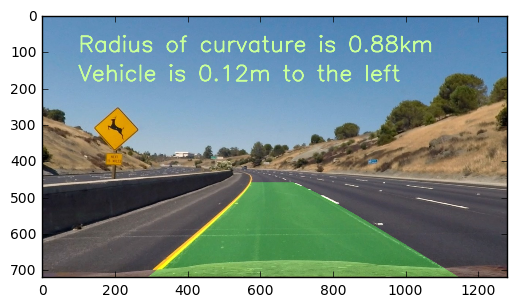

In [59]:
# left_lane = Lane()
# right_lane = Lane()
def try_curvature_on_test_img():
    t_image = mpimg.imread("test_images/test2.jpg")
    (lanes_drawn_img, left_fit, right_fit) = process_img_with_curvature(t_image)
    plt.figure()
    plt.imshow(lanes_drawn_img)
    
try_curvature_on_test_img()

# Testing on Video

Here I am testing my whole pipeline (undistortion-->edge detection-->perspective transform-->lane detection) on a video. Rest of the pipeline is same as above but there are two significant things to note here.
- First I use sliding window search to detect lane lines and fit a polynomial but after that I use that polynomial to fit next lines instead of blind window search.
- To get smooth results I keep recent values and use an average of them. For now I am using 10 most recent values. I came to this number after playing with multiple values.

In [63]:
#Functions for sanity checks 
import uuid

def is_curvature_right(leftc, rightc):
    cdiff = np.absolute(leftc/1000 - rightc/1000)
#     print('curvature diff: ', cdiff)
    if cdiff > 3:
        return False
    
    return True

def is_lanes_inter_distance_right(distance):
    return ((distance > 3.0) & (distance < 4.0))

def is_lane_detection_correct(img, l_fit, r_fit, l_fit_m, r_fit_m):
    (leftc, rightc) = calculate_lanes_curvature(img, l_fit_m, r_fit_m)
    
    offset = vehicle_offset_from_lane_center(img, l_fit, r_fit)
    distance = calculate_distance_between_lanes(img, l_fit, r_fit)
#     print('distance : ', distance)
    
    c1 = is_curvature_right(leftc, rightc)
    c2 = is_lanes_inter_distance_right(distance)
    
    if (c2 == True) & (c1 == True):
#         print('both curvature and distance conditions are True')
        return True
    
    return False

#to save any images that are hurting overal results
def save_hurting_img(original_img, lanes_drawn_img, warped_binary):
    f1 = str(uuid.uuid4())
    f2 = str(uuid.uuid4())
    mpimg.imsave(("hurting_images/original_" + f1 + ".jpg"), original_img)
    mpimg.imsave(("hurting_images/drawn_" + f1 + ".jpg"), lanes_drawn_img)
    mpimg.imsave(("hurting_images/warped_" + f1 + ".jpg"), warped_binary)





**Following is the Lane class that keeps track of recent values for a single left/right lane line.**

In [61]:
class Lane():
    def __init__(self):
        #first polynomial fitting has been done
        #and now that data can be used for future
        self.is_ready = False
        #fitting done on current frame
        self.current_fit = None
        #fitting in meters per pixel
        self.current_fit_m = None
        #current curvature
        self.current_curvature = None
        #all curvatures
        self.all_curvatures = []
        #current x values for the fitted polynomial
        self.current_x = None
        #all x values over which line was fit
        self.all_x = []
        #all fits
        self.all_fits = []
        #all fits_m
        self.all_fits_m = []
        
        #Iterations count to take avg 
        self.N = 10
        
    def add_fit(self, fit):
        self.current_fit = None
        self.all_fits.append(fit)
        self.is_ready = True
        
    def avg_fit(self):
        n_fits = self.all_fits[-self.N:]
        
        if(len(self.all_fits_m) > self.N):
            self.all_fits = n_fits
        
        return np.mean(np.array(n_fits), axis=0)
        
    def add_fit_m(self, fit_m):
        self.current_fit_m = fit_m
        self.all_fits_m.append(fit_m)
        
    def avg_fit_m(self):
        n_fits = self.all_fits_m[-self.N:]
        
        if(len(self.all_fits_m) > self.N):
            self.all_fits_m = n_fits
            
        return np.mean(np.array(n_fits), axis=0)
        
    def add_curvature(self, c):
        self.current_curvature = c
        self.all_curvatures.append(c)
    
    def avg_curvature(self):
        n_curvatures = self.all_curvatures[-self.N:]
        if(len(self.all_curvatures) > self.N):
            self.all_curvatures = n_curvatures
            
        return np.mean(np.array(n_curvatures))
        
    def add_x(self, x):
        self.current_x = x
        self.all_x.append(x)
        
    def avg_x(self):
        n_x = self.all_x[-self.N:]
        if(len(n_x) > self.N):
            self.all_x = n_x
            
        return np.mean(np.array(n_x), axis=0)
        
        
#####################
#declaring Lane objects for left_lane and right lane
left_lane = Lane()
right_lane = Lane()

**This function is serving as an entry point to polynomial fitting with averaging and selecting between blind window search and improved polynomial fitting based on previous smoothed polynomial fit.**

In [66]:
def process_img_averaged(img):
    #undistort image
    undistorted_img = undistort_img(img, mtx, dist)
    #apply edge detection, perspective transform altogethr 
    warped_binary = get_undistorted_warped_binary_img(img)
    
    #check if blind window search has already been executed and successful
    #if yes then use original polynomial fitting avg of recent n fits to
    #fit new polynomial
    if(left_lane.is_ready):
        (some_img, l_fit, r_fit) = process_img(warped_binary, 
                                               left_lane.avg_fit(), 
                                               right_lane.avg_fit())
    #do a blind window search.
    else:
        (some_img, l_fit, r_fit) = process_img(warped_binary)
        

    #add new value to list of recent values
    #and then use avg_fit to fit new polynomial for smoothed out result
    left_lane.add_fit(l_fit)
    right_lane.add_fit(r_fit)

    #draw lines on original image
    lanes_drawn_img = get_drawn_img(undistorted_img, warped_binary, left_lane.avg_fit(), right_lane.avg_fit())
          
    #return drawn image 
    return lanes_drawn_img

In [37]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [64]:
#initialize global variables to make sure Jupyter does not use cached ones 
left_fit = None
right_fit = None
left_lane = Lane()
right_lane = Lane()

white_output = 'project_video_lanes_detected.mp4'
clip1 = VideoFileClip("project_video.mp4")
white_clip = clip1.fl_image(process_img_averaged) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video project_video_lanes_detected.mp4
[MoviePy] Writing video project_video_lanes_detected.mp4


100%|█████████▉| 1260/1261 [03:01<00:00,  6.99it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_lanes_detected.mp4 

CPU times: user 3min 46s, sys: 32.1 s, total: 4min 18s
Wall time: 3min 2s


In [65]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

# Discussion 

### Problems Faced

- It took me a good amount of time to get perspective transformed image lane lines parallel. Was not that quick. 
- Most of the pipeline was ready quickly but I faced some issues when I ran my pipeline on provided test images. I noticed by looking at the raw fitting of those images that where there were smaller dashed (almost not) lines at the bottom of image and there was also some noise at the bottom the histogram picked noise as the peak x point. I overcame this by taking histogram of 1/3 of height instead of 1/2 which I was using before.
- Then main issues were on video as lane lines detections were all jumpy and on shadows lines were like jumping here and there. I added averaging to overcome that. The number of recent picks were chosen by doing multiple experiments and seeing what works best. 
- Other issues were mostly coding mistakes.

### Algorithm fail cases 

- This algorithm will definitely fail after some time eventually on roads where there are many shadows or no lane lines because it uses only 10 recent fits and if those fits are wrong the next all fits will be wrong. 
- If camera angle changes then this will most likely break. 
- If road is itself very harsh (jumps, scratches) that it itself becomes noise then algorithm will result in poor polynomial fitting.

### Improvements

- This algorithm can be improved if we perform sanity checks and only take values that are of high confidence and discard the ones with very low confidence. Other approach would be to keep weighted average. Like for example assigning more weight to hight confidence values and less weight of low confidence values
- I think edge detection can be improved further as my edge detection technique still adds a lot of noise which sometimes confuses algorithms when road conditions are rough. 
- Blind window search can be improved as it sometimes re-center itself when noise pixels are near lane pixels and moves away from actual lane pixels and toward the noise pixels which results in poor polynomial fit.